# Initial Exploration and Cleansing of cycleJourneys

This is for the initial exploration of the cycleJourneys dataset, primarily focusing on data integrity, and the best approaches to data-cleaning. 

This notebook is experimental and exploratory in nature. The initention is to eventually produce a script to apply all 'final' transformations based on learnings here. 

In [25]:
journeys_path = '..\data\cycle_journeys\JourneysDataCombined.csv'
stations_path = '..\data\cycle_journeys\Station Lookup.csv'

In [77]:
import pandas as pd
import random
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

## Cleanse Stations
We will need to cleanse the station ids as certain files have corrupted schemas. 

But, this could turn-out to be quite a big part of the project! 

## Sample Journeys and Inspect

In [28]:
# We will sample just 5% of journeys, using skiprows
p = 0.01 
random.seed(16)

df_samp = pd.read_csv(
        journeys_path
        ,header=0
        ,sep=','
        ,skiprows=lambda i: i>0 and random.random() > p
        ,parse_dates=['Start Date', 'End Date']
        ,infer_datetime_format=True
)

In [29]:
df_samp.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,Start Date,StartStation Id
0,50754299.0,1320.0,3118.0,2016-10-01 00:50:00,686.0,2016-10-01 00:28:00,166.0
1,50754531.0,4860.0,11001.0,2016-10-01 02:56:00,481.0,2016-10-01 01:35:00,654.0
2,50754559.0,300.0,397.0,2016-10-01 01:45:00,192.0,2016-10-01 01:40:00,244.0
3,50754568.0,300.0,8480.0,2016-10-01 01:50:00,197.0,2016-10-01 01:45:00,230.0
4,50754625.0,840.0,863.0,2016-10-01 02:20:00,664.0,2016-10-01 02:06:00,738.0


In [30]:
df_samp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759387 entries, 0 to 759386
Data columns (total 7 columns):
Rental Id          747021 non-null float64
Duration           745345 non-null float64
Bike Id            747020 non-null float64
End Date           745345 non-null datetime64[ns]
EndStation Id      745190 non-null float64
Start Date         747021 non-null datetime64[ns]
StartStation Id    747021 non-null float64
dtypes: datetime64[ns](2), float64(5)
memory usage: 40.6 MB


## Start Dates

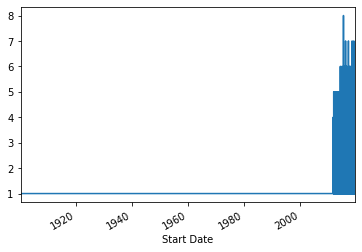

In [31]:
# Plot timeseries of journey volumes
df_samp.groupby('Start Date').count()['Rental Id'].plot()

**issue:** A handful of rows have 1900 start-dates, but such cases it appears End Date is valid, we can just reverse-engineer the Sart Date

In [32]:
def correct_start_date_errors(df):
    """ Void function: adds 'Start Date 2' column to the dataframe.
    Dataset contains start dates in 1900. In such cases, the complimenting date column appears
    to be correct, as well as the duration. This function attempts to fix the implausible start dates. 
    """
    
    # Correct inplausible start dates 
    df['Start Date 2']= df['Start Date'].where(
        (df['Start Date'] >= '2012') | (df['End Date'] < '2012')  # If start date is after 2012 we can trust it. If end date is before 2012, the fix won't work
        ,df_samp['End Date'] - pd.to_timedelta(df_samp['Duration'], unit='s')  # else: correct start_date using end date
        ,axis=0
    )


In [33]:
correct_start_date_errors(df_samp)

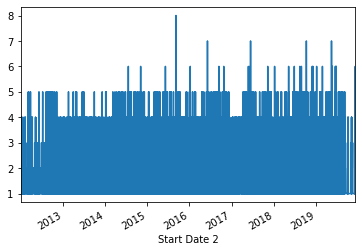

In [34]:
# Plot 'corrected' timeseries of journeys
df_samp.groupby('Start Date 2').count()['Rental Id'].plot()

In `Start Date 2` the error has been corrected

## End Date

### End Dates before 2012

In [64]:
df_samp[df_samp['End Date'] < '2012'].sample(10)

,Rental Id,Duration,Bike Id,End Date,EndStation Id,Start Date,StartStation Id,Start Date 2,End Date 2,EndStation Id 2,Duration 2
262484,16280522.0,-1.347725e+09,5442.0,1970-01-01,0.0,2012-09-15 16:06:00,541.0,2012-09-15 16:06:00,NaT,NaN,NaN
718362,23669984.0,-1.375204e+09,7848.0,1970-01-01,0.0,2013-07-30 17:14:00,16.0,2013-07-30 17:14:00,NaT,NaN,NaN
718072,23659061.0,-1.375091e+09,3341.0,1970-01-01,0.0,2013-07-29 09:42:00,64.0,2013-07-29 09:42:00,NaT,NaN,NaN
372592,19050085.0,-1.357841e+09,1786.0,1970-01-01,NaN,2013-10-01 18:02:00,236.0,2013-10-01 18:02:00,NaT,NaN,NaN
429097,10901900.0,0.000000e+00,2574.0,1970-01-01,0.0,2012-03-25 09:10:00,78.0,2012-03-25 09:10:00,NaT,NaN,NaN
52927,24724171.0,-1.378278e+09,6139.0,1970-01-01,0.0,2013-04-09 06:56:00,167.0,2013-04-09 06:56:00,NaT,NaN,NaN
429122,10903910.0,0.000000e+00,7330.0,1970-01-01,0.0,2012-03-25 14:12:00,213.0,2012-03-25 14:12:00,NaT,NaN,NaN
673631,22857846.0,-1.373050e+09,5053.0,1970-01-01,0.0,2013-05-07 18:53:00,91.0,2013-05-07 18:53:00,NaT,NaN,NaN
239630,15668397.0,-1.346352e+09,8871.0,1970-01-01,0.0,2012-08-30 18:34:00,506.0,2012-08-30 18:34:00,NaT,NaN,NaN
462333,20251146.0,-1.363533e+09,4028.0,1970-01-01,0.0,2013-03-17 15:03:00,210.0,2013-03-17 15:03:00,NaT,NaN,NaN


In [37]:
df_samp[df_samp['End Date'] < '2012']['EndStation Id'].value_counts()

0.0    2624
Name: EndStation Id, dtype: int64

In [50]:
df_samp[df_samp['End Date'] < '2012']['Start Date 2'].dt.year.value_counts()

2013    1520
2012    1251
Name: Start Date 2, dtype: int64

Some rows have an end date on the epoch. These all occur in 2012-2013 and in every case the EndStation Id is '0' (NA)

I suspect that these are journeys without an EndStation (i.e. theft etc) and that the End Date was supposed to be 'NaT' but got replaced with zero, which was then interpreted as 1970-01-01

To test this, I will see if there are similar volumes of 'NaT' after 2013

In [49]:
# Volumes of NaT over years
df_samp[df_samp['End Date'].isna()]['Start Date 2'].dt.year.value_counts()

2016.0    1047
2017.0     629
Name: Start Date 2, dtype: int64

In [51]:
df_samp[df_samp['EndStation Id'].isna() | (df_samp['EndStation Id']==0)]['Start Date 2'].dt.year.value_counts()

2013.0    1520
2012.0    1297
2016.0    1053
2017.0     629
2015.0       1
2014.0       1
Name: Start Date 2, dtype: int64

For unknown reasons 'lost bike journeys' seem to be absent from the 2014/2015 datasets. 

But, the volumes of End Stations and End Dates == 0 in 2012-2013 are comparable to the volumes where they are NaN and NaT respectively in 2016/2017. 

So, the best action is to replace NaN/NaT

In [59]:
def correct_0_end_date_stations(df):
    """ Void function: adds 'End Date 2' and 'EndStation Id 2' and 'Duration 2' columns to the dataframe.
    In 2012/2013, missing end dates and missing end stations are encoded as 1970-01-01 and 0, respectively. 
    This function replaces those cases with NaT and NaN
    """
    
    # Replace 1970 End Dates with NaT 
    df['End Date 2']= df['End Date'].where(
        df['End Date'] >= '2012'
        ,pd.NaT
        ,axis=0
    )
    
    df['Duration 2']= df['Duration'].where(
        (df['End Date'] >= '2012') & (df['Duration'] >= 0)
        ,np.NaN
        ,axis=0
    )
    
    df['EndStation Id 2'] = df['EndStation Id'].where(
        df['EndStation Id'] != 0
        ,np.NaN
    )


In [60]:
correct_0_end_date_stations(df_samp)

In [63]:
df_samp[df_samp['End Date'] < '2012'].sample(5)

,Rental Id,Duration,Bike Id,End Date,EndStation Id,Start Date,StartStation Id,Start Date 2,End Date 2,EndStation Id 2,Duration 2
461301,20136965.0,-1.362945e+09,2437.0,1970-01-01,0.0,2013-10-03 19:49:00,483.0,2013-10-03 19:49:00,NaT,NaN,NaN
494833,20657858.0,-1.365686e+09,1705.0,1970-01-01,0.0,2013-11-04 13:14:00,192.0,2013-11-04 13:14:00,NaT,NaN,NaN
350741,18367586.0,-1.354455e+09,900.0,1970-01-01,0.0,2012-02-12 13:23:00,486.0,2012-02-12 13:23:00,NaT,NaN,NaN
428167,10807465.0,0.000000e+00,2853.0,1970-01-01,0.0,2012-03-22 07:59:00,324.0,2012-03-22 07:59:00,NaT,NaN,NaN
324304,17676809.0,-1.351948e+09,4276.0,1970-01-01,0.0,2012-03-11 13:08:00,503.0,2012-03-11 13:08:00,NaT,NaN,NaN


End Date / Negative Duration Issue corrected. 

## Duration

Whilst fixing the 1970 end dates issue, I should have also fixed the 'negative duration' issue with the `Duration 2` field. 

Explore whether there are any other issues with this field

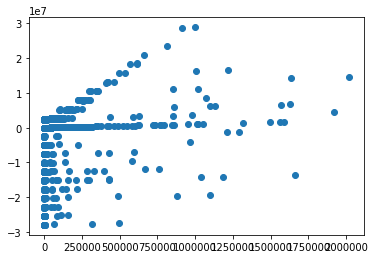

In [67]:
# Compare Duration 2 field with a manually-calculated duration field to validate
df_samp['duration_from_dates'] = (df_samp['End Date 2'] - df_samp['Start Date 2'])/np.timedelta64(1,'s')
plt.scatter(df_samp['Duration 2'].tolist(), df_samp['duration_from_dates'].tolist())

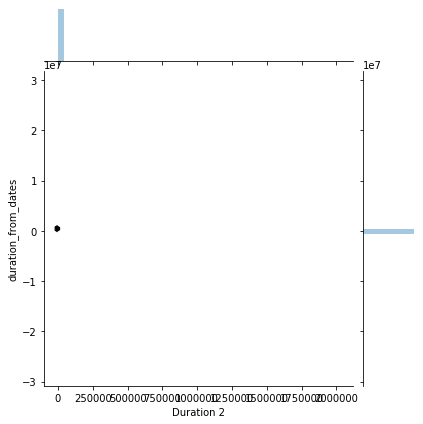

In [92]:
sns.jointplot(
    x="Duration 2"
    , y="duration_from_dates"
    , data=df_samp
    , kind="hex")

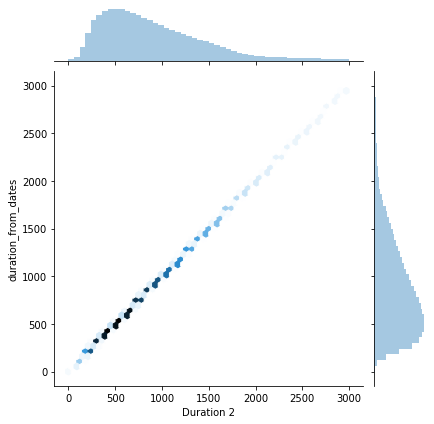

In [84]:
zoom = (df_samp['Duration 2'] < 3000) & (df_samp['duration_from_dates'] < 3000) & (df_samp['duration_from_dates'] >= 0)

sns.jointplot(
    x="Duration 2"
    , y="duration_from_dates"
    , data=df_samp[zoom]
    , kind="hex")

In [73]:
df_samp['End Date from Duration'] = df_samp['Start Date 2'] + pd.to_timedelta(df_samp['Duration 2'], unit='s')

In [74]:
df_samp[df_samp['duration_from_dates'] != df_samp['Duration 2']].sample(10)

,Rental Id,Duration,Bike Id,End Date,EndStation Id,Start Date,StartStation Id,Start Date 2,End Date 2,EndStation Id 2,Duration 2,duration_from_dates,End Date from Duration
629779,68524197.0,1192.0,13174.0,2017-08-17 17:29:00,387.0,2017-08-17 17:09:00,15.0,2017-08-17 17:09:00,2017-08-17 17:29:00,387.0,1192.0,1200.0,2017-08-17 17:28:52
328828,18133184.0,5242.0,3188.0,2012-11-21 05:49:00,462.0,2012-11-21 04:22:00,425.0,2012-11-21 04:22:00,2012-11-21 05:49:00,462.0,5242.0,5220.0,2012-11-21 05:49:22
716498,23582817.0,562.0,2926.0,2013-07-26 09:05:00,239.0,2013-07-26 08:56:00,581.0,2013-07-26 08:56:00,2013-07-26 09:05:00,239.0,562.0,540.0,2013-07-26 09:05:22
325329,17781083.0,1581.0,8285.0,2012-07-11 09:39:00,104.0,2012-07-11 09:12:00,197.0,2012-07-11 09:12:00,2012-07-11 09:39:00,104.0,1581.0,1620.0,2012-07-11 09:38:21
228636,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaT
632537,68824998.0,312.0,14081.0,2017-08-26 20:42:00,697.0,2017-08-26 20:37:00,804.0,2017-08-26 20:37:00,2017-08-26 20:42:00,697.0,312.0,300.0,2017-08-26 20:42:12
557546,21530512.0,426.0,4728.0,2013-05-16 07:06:00,48.0,2013-05-16 06:59:00,173.0,2013-05-16 06:59:00,2013-05-16 07:06:00,48.0,426.0,420.0,2013-05-16 07:06:06
265063,16551007.0,717.0,3204.0,2012-09-24 17:49:00,457.0,2012-09-24 17:37:00,98.0,2012-09-24 17:37:00,2012-09-24 17:49:00,457.0,717.0,720.0,2012-09-24 17:48:57
262511,16283512.0,447.0,5579.0,2012-09-15 13:21:00,527.0,2012-09-15 13:14:00,158.0,2012-09-15 13:14:00,2012-09-15 13:21:00,527.0,447.0,420.0,2012-09-15 13:21:27
418819,19576770.0,422.0,9060.0,2013-08-02 11:47:00,94.0,2013-08-02 11:40:00,194.0,2013-08-02 11:40:00,2013-08-02 11:47:00,94.0,422.0,420.0,2013-08-02 11:47:02


In [75]:
df_samp[df_samp['duration_from_dates'] < 0]

,Rental Id,Duration,Bike Id,End Date,EndStation Id,Start Date,StartStation Id,Start Date 2,End Date 2,EndStation Id 2,Duration 2,duration_from_dates,End Date from Duration
4412,51217356.0,91620.0,2309.0,2016-01-02 18:34:00,41.0,2016-01-31 17:07:00,311.0,2016-01-31 17:07:00,2016-01-02 18:34:00,41.0,91620.0,-2500380.0,2016-02-01 18:34:00
7106,51495675.0,420.0,8336.0,2016-02-13 00:00:00,113.0,2016-12-02 23:53:00,157.0,2016-12-02 23:53:00,2016-02-13 00:00:00,113.0,420.0,-25401180.0,2016-12-03 00:00:00
12848,52101691.0,10440.0,7697.0,2016-03-13 00:00:00,407.0,2016-12-03 21:06:00,407.0,2016-12-03 21:06:00,2016-03-13 00:00:00,407.0,10440.0,-22971960.0,2016-12-04 00:00:00
12858,52102738.0,1320.0,6146.0,2016-03-13 00:01:00,386.0,2016-12-03 23:39:00,427.0,2016-12-03 23:39:00,2016-03-13 00:01:00,386.0,1320.0,-22981080.0,2016-12-04 00:01:00
17067,52538845.0,900.0,6210.0,2016-01-04 00:10:00,690.0,2016-03-31 23:55:00,638.0,2016-03-31 23:55:00,2016-01-04 00:10:00,690.0,900.0,-7602300.0,2016-04-01 00:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754826,37319058.0,300.0,10918.0,2014-09-13 00:01:00,131.0,2014-12-09 23:56:00,69.0,2014-12-09 23:56:00,2014-09-13 00:01:00,131.0,300.0,-7602900.0,2014-12-10 00:01:00
754827,37319086.0,840.0,8876.0,2014-09-13 00:12:00,600.0,2014-12-09 23:58:00,154.0,2014-12-09 23:58:00,2014-09-13 00:12:00,600.0,840.0,-7602360.0,2014-12-10 00:12:00
757653,47762119.0,57600.0,1605.0,2015-09-13 06:07:00,620.0,2015-12-09 14:07:00,597.0,2015-12-09 14:07:00,2015-09-13 06:07:00,620.0,57600.0,-7545600.0,2015-12-10 06:07:00
757782,47776339.0,20160.0,5220.0,2015-09-13 01:20:00,595.0,2015-12-09 19:44:00,730.0,2015-12-09 19:44:00,2015-09-13 01:20:00,595.0,20160.0,-7583040.0,2015-12-10 01:20:00


It seems that in some cases, the End Date (or start date??) is wrong but the times are in fact correct. It seems that timings around midnight or the new year might be some cases. 

I think a possible approach might be to contrast Duration 2 and duration_from_dates and to pick the one that is more 'plausible' in each case. 

'plausible' might be measured by how many standard deviations is is away from the mean. Or perhaps, Duration 2 is always the best option

End Date is also broken!